In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os

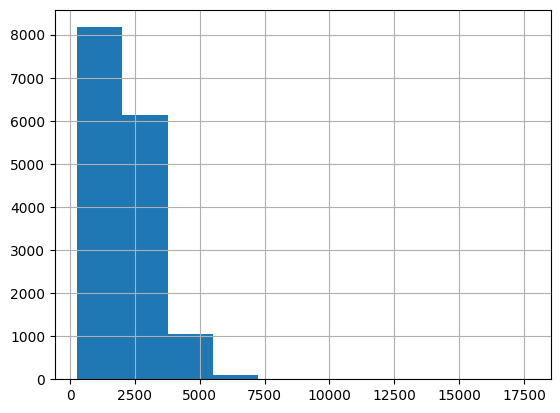

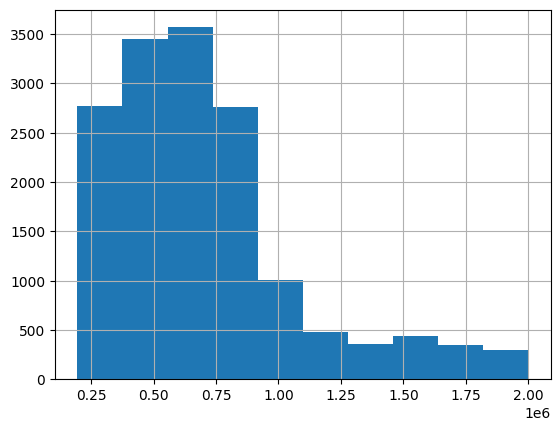

price_range
mid     10927
low      2448
high     2099
Name: count, dtype: int64

In [2]:
# Example 1

DATA_PATH = "/home/bule/TramDag/data"
# toy example  https://www.kaggle.com/datasets/ted8080/house-prices-and-images-socal

# import kagglehub
# kagglehub.dataset_download("ted8080/house-prices-and-images-socal", path=DATA_PATH)

# X0 sqrft continous
# X1 Images
# X2 Price in ranges low, mid , high 
houses_df=pd.read_csv(os.path.join(DATA_PATH ,"socal2.csv"))

# X0 -> squarfoot continous
houses_df['sqft'].hist()
plt.show()

# X1 -> images
image_paths=[os.path.join(DATA_PATH,"socal2/socal_pics",pth) for pth in os.listdir(os.path.join(DATA_PATH, "socal2/socal_pics"))]
houses_df['image_paths']=image_paths

# X2 prices -> ordinal
houses_df['price'].hist()
plt.show()

houses_df['price_range'] = pd.cut(
    houses_df['price'], 
    bins=[0, 350_000, 1_000_000, float('inf')],  # Adjust bin edges
    labels=['low', 'mid', 'high'],  
    include_lowest=True  # Ensures 0 is included in 'low'
)
houses_df['price_range'].value_counts()


In [3]:
houses_df

,image_id,street,citi,n_citi,bed,bath,sqft,price,image_paths,price_range
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900,/home/bule/TramDag/data/socal2/socal_pics/1183...,low
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500,/home/bule/TramDag/data/socal2/socal_pics/68.jpg,low
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950,/home/bule/TramDag/data/socal2/socal_pics/7463...,low
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000,/home/bule/TramDag/data/socal2/socal_pics/2530...,low
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100,/home/bule/TramDag/data/socal2/socal_pics/2001...,mid
...,...,...,...,...,...,...,...,...,...,...
15469,15469,4156 Sterlingview Drive,"Moorpark, CA",227,5,4.1,4092,949000,/home/bule/TramDag/data/socal2/socal_pics/857.jpg,mid
15470,15470,4355 Avenida Prado,"Thousand Oaks, CA",372,5,3.0,2773,949900,/home/bule/TramDag/data/socal2/socal_pics/3955...,mid
15471,15471,12717 Koenigstein Rd Road,"Santa Paula, CA",338,3,2.0,1576,920000,/home/bule/TramDag/data/socal2/socal_pics/1294...,mid
15472,15472,36 Kunkle Street,"Oak View, CA",253,4,2.0,2086,997000,/home/bule/TramDag/data/socal2/socal_pics/6270...,mid


## Ranodm Forest 

Mean Absolute Error: 223009.59
R² Score: 0.31


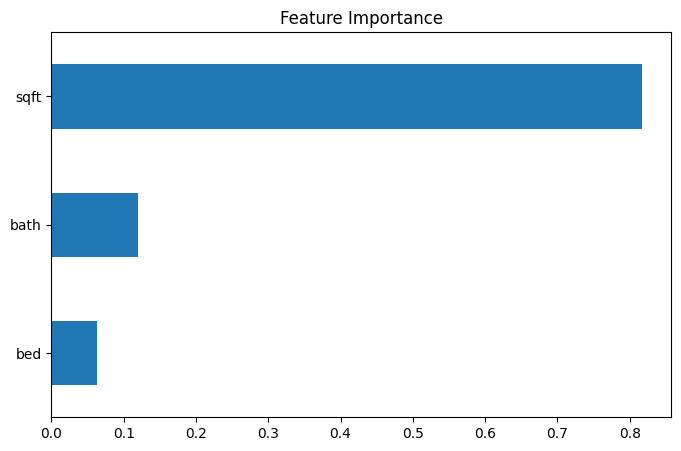

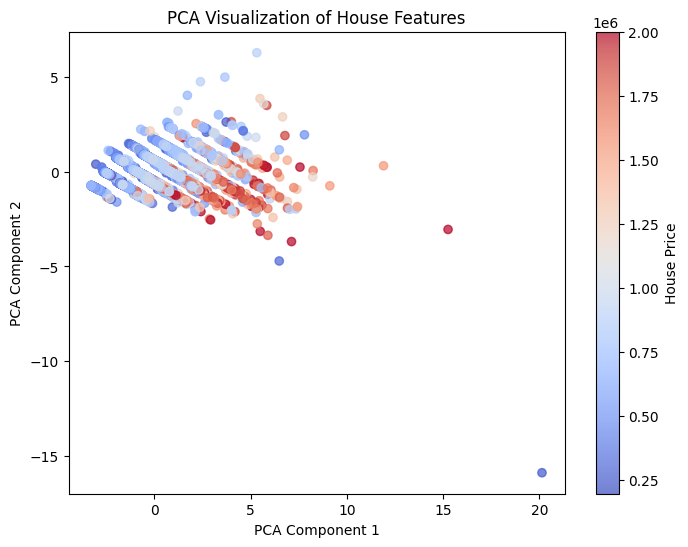

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Define features and target
X = houses_df[['bath', 'sqft', 'bed']]
y = houses_df['price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature Importance
feature_importance = pd.Series(rf.feature_importances_, index=['bath', 'sqft', 'bed'])
feature_importance.sort_values().plot(kind='barh', figsize=(8, 5), title="Feature Importance")

plt.show()

# Apply PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot of PCA components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label="House Price")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of House Features")
plt.show()

### Image Model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
df=houses_df
# Load DataFrame
# df = pd.read_csv("data.csv")  # Replace with your actual DataFrame source
df['price_range'] = df['price_range'].map({'low': 0, 'mid': 1, 'high': 2})  # Encode labels

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['price_range'], random_state=42)

# Define a PyTorch dataset
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_paths']
        label = self.df.iloc[idx]['price_range']
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets and loaders
train_dataset = ImageDataset(train_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Load a pre-trained ViT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vit_b_16(pretrained=True)

# Modify the classifier for 3 classes
model.heads.head = nn.Linear(model.heads.head.in_features, 3)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Evaluation on the test set
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 97/97 [02:13<00:00,  1.38s/it]


Epoch 1/5, Loss: 0.8203, Accuracy: 70.18%


100%|██████████| 97/97 [02:14<00:00,  1.39s/it]


Epoch 2/5, Loss: 0.8088, Accuracy: 70.62%


100%|██████████| 97/97 [02:14<00:00,  1.39s/it]


Epoch 3/5, Loss: 0.7896, Accuracy: 70.66%


100%|██████████| 97/97 [02:14<00:00,  1.39s/it]


Epoch 4/5, Loss: 0.7149, Accuracy: 71.77%


100%|██████████| 97/97 [02:14<00:00,  1.39s/it]

Epoch 5/5, Loss: 0.5511, Accuracy: 77.45%


Test Accuracy: 65.98%


# REsnet 18

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Assuming houses_df is already defined
df = houses_df.copy()

# Encode labels
df['price_range'] = df['price_range'].map({'low': 0, 'mid': 1, 'high': 2})  

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['price_range'], random_state=42)

# Define a PyTorch dataset
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_paths']
        label = self.df.iloc[idx]['price_range']
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets and loaders
train_dataset = ImageDataset(train_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Load a pre-trained ResNet-18 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Modify the fully connected layer for 3 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Evaluation on the test set
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/bule/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]
100%|██████████| 97/97 [00:16<00:00,  6.05it/s]


Epoch 1/5, Loss: 0.8941, Accuracy: 64.11%


100%|██████████| 97/97 [00:15<00:00,  6.35it/s]


Epoch 2/5, Loss: 0.6921, Accuracy: 71.19%


100%|██████████| 97/97 [00:15<00:00,  6.33it/s]


Epoch 3/5, Loss: 0.5259, Accuracy: 77.32%


100%|██████████| 97/97 [00:15<00:00,  6.31it/s]


Epoch 4/5, Loss: 0.3682, Accuracy: 86.45%


100%|██████████| 97/97 [00:15<00:00,  6.34it/s]


Epoch 5/5, Loss: 0.3019, Accuracy: 88.90%
Test Accuracy: 64.01%
